# CS345 Final Project Report
### By: Andy Borch and Xander Gupton

For our project, we wanted to investigate how different features of a data collection effected the efficiency of various sorting algorithms and if that effect could be predicted using machine learning. We sought to create a dataset of collections and feed them into a variety of popular sorting algorithms to gather data on the efficiency of the algorithms. 

Initally, we searched for a dataset which would contain the proper data we required, but after some digging we came up empty handed. Thus, we decided to use our newfound knowledge and experience with Numpy to build our own dataset of collections. This would allow us to control the various features of each collection and adjust our data if necessary based on more predictive features. The main features we chose to focus on for our collections were size, mean, standard deviation, and number of unique elements. Additionally, each collection had a data type associated with it. We chose to use lists, tuples, sets, Pandas Series and Numpy arrays. We used a binary encoding to specify each collection type. For example, for a list, the feature for lists would be '1', and everything else would be '0'. This allowed us to add in the data type to our features. Finally, we have features for the runtime of each sorting algorithm. Each collection was passed into each sorting algorithm and the runtime was recorded. It was then added to our features dataset. These runtimes became the target values, allowing us to train models to predict sorting performance based on input features.

In [79]:
#Import statements for all code cells
import numpy as np
import pandas as pd
import csv
import random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import svm
from tensorflow.python import keras
from keras.api.models import Sequential
from keras.api.layers import Dense, Dropout, Input
from keras.api.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [73]:
#Function which generates a random array given a set of inputs
#Size, mean, standard deviation, and number of unique elements all
#controllable
def generate_array(size, mean=0, std=1, n_unique=10):
    if n_unique > size:
        raise ValueError("Number of unique elements cannot exceed array size.")

    half = n_unique // 2
    if n_unique % 2 == 0:
        unique_vals = np.arange(-half, half)
    else:
        unique_vals = np.arange(-half, half + 1)

    unique_vals = (unique_vals * std) + mean
    unique_vals = unique_vals.astype(np.int64)

    sampled = np.random.choice(unique_vals, size=size, replace=True)

    return sampled

#Code which generates an equally spread matrix of values to 
#assign data structure type to each array, similar to "one-hot encoding"
#but instead of creating off of existing data it's randomized with an equal spread.
#Creates a set of identity matrices and then shuffles the rows. 
def generate_data_structure_array(num_points):
    features = np.identity(5, dtype=np.int64)
    for x in range(int(num_points/5 - 1)):
        new_ident = np.identity(5, dtype=np.int64)
        features = np.concatenate((features, new_ident))
    for y in range(num_points%5):
        features = np.vstack((features, [1, 0, 0, 0, 0, 0]))
    np.random.shuffle(features)
    return features

#Ranges for the various variables used in arrays
min_size, max_size = 1000, 10000
min_mean, max_mean = 50, 100
min_stddev, max_stddev = .1, 1
min_unique, max_unique = 0.7, 1
num_points = 10000
data_structure_features = generate_data_structure_array(num_points)

raw_features = np.empty(shape=(num_points, 9))

#Loop through number of desired arrays and randomize 
#each feature based on range provided above
for x in range(num_points):
    size = np.random.randint(min_size, max_size)
    mean = np.random.randint(min_mean, max_mean)
    stddev = np.random.uniform(min_stddev, max_stddev)
    percent_unique = np.random.uniform(min_unique, max_unique)
    num_unique = int(size * percent_unique)

    arr = generate_array(size, mean, stddev, num_unique)

    features = [size, np.mean(arr), np.std(arr), len(np.unique(arr))]
    features = features + data_structure_features[x].tolist()
    raw_features[x] = features

data = raw_features[0:5, :]
print("Example arrays generated:")
pd.DataFrame(data, columns = ['Size', 'Mean', 'Standard Deviation' ,'Number of Unique Elements', "is_array", "is_list","is_tuple","is_set","is_nparray",])


Example arrays generated:


,Size,Mean,Standard Deviation,Number of Unique Elements,is_array,is_list,is_tuple,is_set,is_nparray
0,4515.0,78.509856,948.081030,2459.0,0.0,0.0,0.0,1.0,0.0
1,2738.0,65.192841,462.920095,1264.0,0.0,1.0,0.0,0.0,0.0
2,5704.0,55.743338,273.258071,941.0,0.0,0.0,0.0,1.0,0.0
3,4415.0,50.522990,433.782017,1425.0,0.0,0.0,0.0,1.0,0.0
4,4212.0,54.457977,1082.498866,2496.0,0.0,0.0,1.0,0.0,0.0


### Array Generation and Sorting Algorithms

The above code written by Xander generates two different CSV files, one which contains the raw arrays generated based on the given feature ranges, and one which contains the features of each array as well as a randomly assigned data structure. The different data structures we chose to investigate were Python's implementations of arrays, lists, sets, and tuples, as well as Numpy arrays and Panda's series. 

Now that we had code to generate our data, we moved onto implementing the various sorting algorithms. Initially, we didn't have a very methodical way of choosing the algorithms we would use. We started by choosing an assortment of algorithms that had a wide range of time complexities, as we felt the model would be able to account for the various differences. We would later learn this was a mistake, but that will be explained shortly. 

The first set of sorting algorithms we chose were merge sort, quick sort, heap sort, bubble sort, insertion sort, bucket sort, and radix sort. The implementations used were typical implementations found online. One problem that arose was Python's recursion depth limit. The dataset we were using exceeded the recursion depth rather quickly. The fix was simple, in that recursive implementations were changed to iterative ones. 

Another aspect we had to consider was how we would implement the different algorithms for the different data structures we had in our dataset. Some of the collections in our dataset were immutable, so in order to sort them, they had to be converted into a mutable data structure type. We decided to do this in each sorting algorithm, and that the time to convert the data type would be built into the data so the model would take that into account in it's predictions.  

In [ ]:
def merge_sort_helper(arr):
    if len(arr) <= 1:
        return arr
    mid = len(arr) // 2
    left = merge_sort_helper(arr[:mid])
    right = merge_sort_helper(arr[mid:])
    return merge(left, right)

def merge(left, right):
    result = []
    i = j = 0
    while i < len(left) and j < len(right):
        if left[i] < right[j]:
            result.append(left[i])
            i += 1
        else:
            result.append(right[j])
            j += 1
    result.extend(left[i:])
    result.extend(right[j:])
    return result

def merge_sort(data):
    if isinstance(data, (tuple, set, pd.Series)):
        data = list(data)
    return merge_sort_helper(data)

def heapify(arr, n, i):
    largest = i
    left = 2 * i + 1
    right = 2 * i + 2

    if left < n and arr[largest] < arr[left]:
        largest = left

    if right < n and arr[largest] < arr[right]:
        largest = right

    if largest != i:
        arr[i], arr[largest] = arr[largest], arr[i]
        heapify(arr, n, largest)

def heap_sort(data):
    if isinstance(data, tuple) or isinstance(data, set):
        data = list(data)
    n = len(data)
    for i in range(n // 2 - 1, -1, -1):
        heapify(data, n, i)

    for i in range(n - 1, 0, -1):
        data[0], data[i] = data[i], data[0]
        heapify(data, i, 0)
    return data

def bubble_sort(data):
    if isinstance(data, tuple) or isinstance(data, set):
        data = list(data)

    n = len(data)
    for i in range(n):
        for j in range(0, n - i - 1):
            if data[j] > data[j + 1]:
                data[j], data[j + 1] = data[j + 1], data[j]
    return data

def insertion_sort(data):
    if isinstance(data, tuple) or isinstance(data, set):
        data = list(data)
    for i in range(1, len(data)):
        key = data[i]
        j = i - 1
        while j >= 0 and key < data[j]:
            data[j + 1] = data[j]
            j -= 1
        data[j + 1] = key
    return data
    
def quick_sort(data):
    if isinstance(data, tuple) or isinstance(data, set):
        data = list(data)

    stack = [(0, len(data) - 1)]

    while stack:
        start, end = stack.pop()
        if start >= end:
            continue

        pivot = data[end]
        i = start
        for j in range(start, end):
            if data[j] < pivot:
                data[i], data[j] = data[j], data[i]
                i += 1
        data[i], data[end] = data[end], data[i]

        stack.append((start, i - 1))
        stack.append((i + 1, end))
    return data

def quick_sort_helper(arr):
    if len(arr) <= 1:
        return arr
    pivot = random.choice(arr)
    left = [x for x in arr if x < pivot]
    middle = [x for x in arr if x == pivot]
    right = [x for x in arr if x > pivot]
    return quick_sort_helper(left) + middle + quick_sort_helper(right)

def radix_sort(data):
    if isinstance(data, tuple) or isinstance(data, set):
        data = list(data)
    if len(data) == 0:
        return data
    
    #data = [int(x) for x in data]

    max_num = max(data)
    exp = 1
    while max_num // exp > 0:
        counting_sort(data, exp)
        exp *= 10
    return data

def bucket_sort(data):
    #Must convert np array and pd Series to list because they
    #dont have clear and extend methods
    if isinstance(data, (tuple, set, np.ndarray, pd.Series)):
        data = list(data)
    if len(data) == 0:
        return data

    min_value = min(data)
    max_value = max(data)
    bucket_count = len(data)
    buckets = [[] for _ in range(bucket_count)]

    for num in data:
        index = int((num - min_value) * (bucket_count - 1) / (max_value - min_value))
        buckets[index].append(num)

    data.clear()
    for bucket in buckets:
        insertion_sort(bucket)
        data.extend(bucket)
    return data

### Timing code
The code used to generate the run time data is listed below. It loads both the collections dataset and the associated features. It then creates a Pandas DataFrame to make accessing the data simpler. Then each collection is passed into each sorting algorithm and run time is recorded. The result is a DataFrame of run time in seconds for each collection and each sorting algorithm. This data is then appended to the features file for training. 

In [ ]:
def time_sort():
    timing_data = []

    for i in range(len(data)):
        dataset_results = {}
        dataset_results["Dataset"] = f"Dataset {i+1}"
        current_data = data[i]

        sorts = [
            ("Bubble", bubble_sort),
            ("Insertion", insertion_sort),
            ("Merge", merge_sort),
            ("Quick", quick_sort),
            ("Heap", heap_sort),
            ("Radix", radix_sort),
            ("Bucket", bucket_sort),
        ]

        for sort_name, sort_fn in sorts:
            start = time.perf_counter()
            sort_fn(current_data)
            end = time.perf_counter()
            dataset_results[sort_name] = end - start

        timing_data.append(dataset_results)

    return pd.DataFrame(timing_data)

### Problems with algorithms
After we generated timing data we ran into an unfortunate problem. There were some algorithms which were so much better than others that they outperformed the rest on almost every single collection. For example, bucket sort only has a time complexity of O(n + k), while many of the others have complexities of O(n^2) and O(n log n). When we began to create labels for the model to train on, we found that bucket sort was being chosen for every single collection, making our data essentially useless as there was no actual prediction to be made. In hindsight, we could have seen this coming, but, given we didn't, we had to find a way to adjust. 

We initially chose to pivot to using only algorithms which had similar time complexities. After doing some research, we found that Heap Sort and Merge Sort had O(n log n) for all cases and Quick Sort had O(n log n) except for in the worst case where it is O(n^2). We wanted to move forward with only data from these three algorithms, as otherwise we would never be able to train a useful model as the answer could be easily seen from the existing data with the naked eye. We reran the timing code using just these sorting algorithms but ran into the same problem. We attempted to manipulate the various features, adjusting the size, mean, standard deviation, and number of unique elements as much as we could but found no solution to one of the algorithms being inherently faster than the rest. We didn't anticipate that the features we provided wouldn't provide enough nuance in the collections to systematically give varying results for the timing algorithms. Thus, we created syntheic data to simulate what a model could infer from the features of the collections we had. 

These plot below shows the relationship between the various features of our generated data on the X axis and the timing of the sorting algorithms on the Y axis. Visually, the data doesn't show much correlation between the times obtained from running the algorithms and the various features we chose. This should have been our first sign that the features of the arrays weren't going to be predictive enough to provide a reasonable and realistic dataset. 

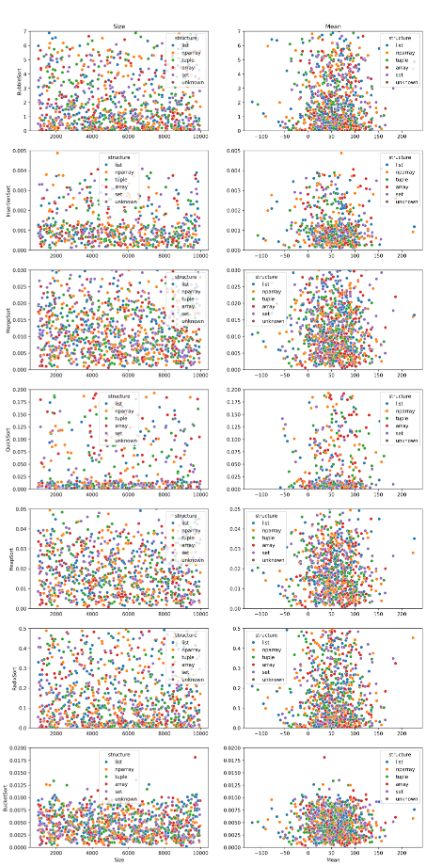

In the end, we decided to create synthetic timing data instead of using the actual timing data we generated. We retained the Size, Mean, Standard Deviation and Number of Unique Elements as our features, but generated run time data based on mathematical equations rather than real world results. To simulate realistic behavior, each sorting algorithm runtime was determined using a mathematical function based on the four features. Each function included a randomized Y intercept from a range that overlapped with the other algorithms, a variety of feature weightings to simulate different algorithms performing better or worse depending on the data collection provided, and some random noise. The weights were determined with help from ChatGPT in order to get realistic, yet suffifiently different behaviors from each mock sorting algorithm. This allowed us to have a dataset that was realistic and had enough correlation between features and run times.

The graphs below show a visualization of the weights we chose to apply to each of the features of the arrays for the model. Based on the weight given, it would influence how predictive that feature would be on the given time calculated for the associated array.

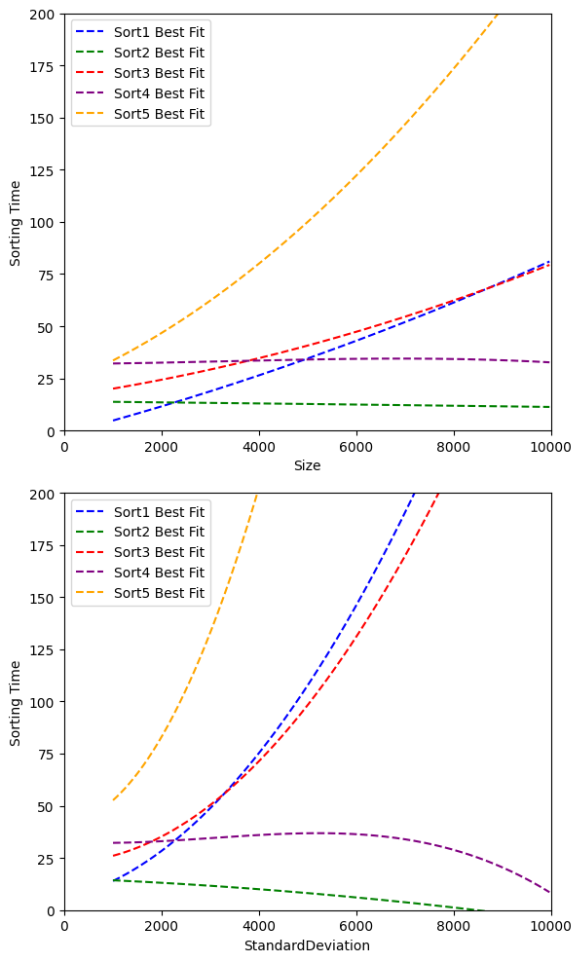


The synthetic data generation code is provided in the next cell.

In [74]:
def generate_random_features(row, noise_scale=10):
    size = row[0]
    mean = row[1]
    stddev = row[2]
    numUnique = row[3]

    base_sort_time = (size / 1000) + random.uniform(-5, 5)

    y_intercept1 = random.uniform(0, 15)
    y_intercept2 = random.uniform(10, 20)
    y_intercept3 = random.uniform(15, 30)
    y_intercept4 = random.uniform(25, 40)
    y_intercept5 = random.uniform(35, 50)

    noise = lambda: random.uniform(-noise_scale, noise_scale)

    sort1 = y_intercept1
    sort1 += -0.4 * (size / 1000)
    sort1 += 0.6 * (stddev / 100)
    sort1 += -0.02 * ((size / 1000) ** 2)
    sort1 += 0.03 * ((stddev / 100) ** 2)
    sort1 += 0.1 * (mean / 100)
    sort1 += noise()

    sort2 = y_intercept2
    sort2 += 0.3 * (size / 1000)
    sort2 += -0.2 * (stddev / 100)
    sort2 += -0.05 * ((mean / 100) ** 3)
    sort2 += 0.04 * ((numUnique / 1000) ** 2)
    sort2 += noise()

    sort3 = y_intercept3
    sort3 += 0.5 * np.log1p(size) / 10
    sort3 += 0.03 * ((stddev / 100) ** 2)
    sort3 += 0.1 * (mean / 100)
    sort3 += -0.02 * ((numUnique / 1000) ** 2)
    sort3 += noise()

    sort4 = y_intercept4
    sort4 += -0.3 * ((numUnique / 1000) - 2) ** 2
    sort4 += 0.01 * ((mean / 100) ** 3)
    sort4 += 0.1 * (stddev / 100)
    sort4 += -0.01 * (size / 1000)
    sort4 += noise()

    sort5 = y_intercept5
    sort5 += 0.08 * (mean / 100)                             
    sort5 += 0.1 * ((mean / 100 - 1.5) ** 2)                  
    sort5 += 0.1 * ((stddev / 100) ** 2)                 
    sort5 += 0.05 * (size / 1000)                                
    sort5 += -0.2 * ((numUnique / 1000 - 2) ** 2)               
    sort5 += noise()

    return [sort1, sort2, sort3, sort4, sort5]

### Data Processing

Once we were happy with the state of our data, we moved onto preprocessing our data. We felt there wasn't too much we could perform to improve the model's performance, and thus we decided to mainly focus on standardizing our very large features. Having numbers well into the thousands would only prove to hamper a model's performance, so we standardized each row according to how we learned during the course, as shown below. 

In [75]:
def standardize(matrix):
    return (matrix - np.mean(matrix, axis=0)) / np.std(matrix, axis=0)

features = np.array(raw_features)
features_to_standardize = features[:, :4]

floats = features_to_standardize.astype(float)
standardized = standardize(floats)

print("Standard Deviation of each Row should be 1: ", np.std(standardized, axis=0))
print("Mean of each Row should be 0: ", np.round(np.mean(standardized, axis=0)))

features[:, 0:4] = standardized

example_standardized_features = standardized[0:5, :]

print("\nExample of standardized features:")
pd.DataFrame(example_standardized_features, columns = ['Size', 'Mean', 'Standard Deviation' ,'Number of Unique Elements'])


Standard Deviation of each Row should be 1:  [1. 1. 1. 1.]
Mean of each Row should be 0:  [ 0.  0. -0.  0.]

Example of standardized features:


,Size,Mean,Standard Deviation,Number of Unique Elements
0,-2.150095,-4.097810,-1.425397,-1.616512
1,-1.087923,-0.525875,-0.545568,-0.642860
2,0.062699,-1.043616,-0.906041,-0.891665
3,-0.437352,-1.329640,-0.600948,-0.518842
4,-0.516103,-1.114041,0.632007,0.306144


### Model Selection
Our initial idea for a model was a TensorFlow neural network. The idea was that would preform the best on data that was not highly correlated. The neural network we implemented is shown in the code cell below. With the original real world data, the network was only acheiving around 60% accuracy. After training it on our synthetic data, accuracy for the neural network increased to just under 70% accuracy.

Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5616 - loss: 1.1370 - val_accuracy: 0.6760 - val_loss: 0.7638
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6786 - loss: 0.7486 - val_accuracy: 0.6885 - val_loss: 0.7440
Epoch 3/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6820 - loss: 0.7321 - val_accuracy: 0.6785 - val_loss: 0.7485
Epoch 4/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6833 - loss: 0.7368 - val_accuracy: 0.6820 - val_loss: 0.7446
Epoch 5/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6817 - loss: 0.7344 - val_accuracy: 0.6820 - val_loss: 0.7416
Epoch 6/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6783 - loss: 0.7535 - val_accuracy: 0.6770 - val_loss: 0.7521
Epoch 7/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6862 - loss: 0.7228 - val_accuracy: 0.6870 - val_loss: 0.7376
Epoch 8/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6760 - loss: 0.7415 - val_accuracy: 0.

c:\Users\aborc\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aborc\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aborc\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


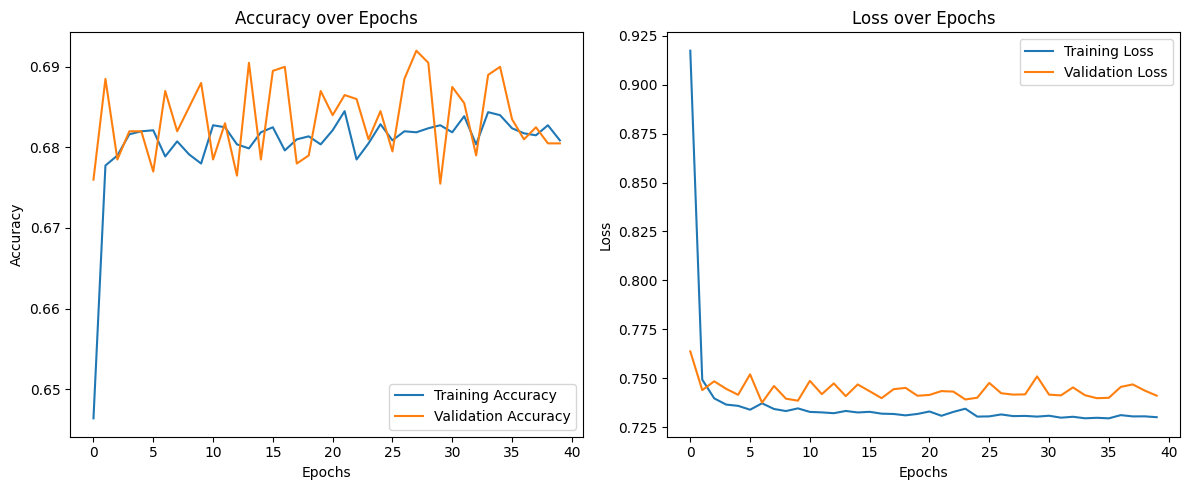

In [ ]:
#only extract Mean, StandardDeviation, and NumUnique
mock_timing_data = np.empty(shape=(len(raw_features), 5))
for i in range(len(raw_features)):
    mock_timing_data[i] = generate_random_features(raw_features[i], 10)

sorts = ['Sort1', 'Sort2', 'Sort3', 'Sort4', 'Sort5']

X = raw_features[:, [0, 2, 3]]
y = np.argmin(mock_timing_data, axis=1)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001) 
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs=40, batch_size=64, validation_data=(X_test_scaled, y_test))

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=[str(cls) for cls in encoder.classes_]))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



### Alternative Models

We also investigated training a few other types of models such as an SVM, random forest, and kNN. Given our smaller dataset, we knew we could train the models and get results relatively quickly to see if we wanted to pivot our efforts. For the SVM and kNN, we performed a grid search to identify the best hyperparamters for the model. Additionally, we experimented with a variety of values of the number of estimators parameter for the random forest model. We found that there wasn't much variation in the accuracy by changing this hyperparameter, so we decided to use the default of 100. We considered using cross validation for these models, but decided against it given we had a larger dataset and cross validation wouldn't be very applicable for our purposes.

In [ ]:
#SVM
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

svc = svm.SVC()

params_svc = [
    {'C': [0.1, 0.5, 1, 3, 5, 7, 10], 
    'gamma': [0.0001, 0.001, 0.1, 1, 2, 3], 
    'kernel': ['rbf']},
]

grid_search_svc = GridSearchCV(svc, param_grid=params_svc, cv=5, n_jobs=-1, verbose=1)

grid_search_svc.fit(X_train, y_train)
best_svc = grid_search_svc.best_estimator_
y_pred_svc = best_svc.predict(X_test)

print("Best SVC Parameters:", grid_search_svc.best_params_)
print("SVC Test Accuracy:", accuracy_score(y_test, y_pred_svc))
print("\nSVC Classification Report:\n", classification_report(y_test, y_pred_svc, zero_division=0))

#Random Forest
forest = RandomForestClassifier(n_estimators=100)

forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)
print('Forest accuracy: ', np.mean(y_test == y_pred_forest), "\n")

#kNN
knn = KNeighborsClassifier()

params = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

grid_search_knn = GridSearchCV(knn, param_grid=params, cv=5, n_jobs=-1, verbose=1)

grid_search_knn.fit(X_train, y_train)
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

print("Best Parameters:", grid_search_knn.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn, zero_division=0))

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best SVC Parameters: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC Test Accuracy: 0.6516666666666666

SVC Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.86      0.76      1831
           1       0.57      0.37      0.45      1047
           2       0.00      0.00      0.00       110
           3       0.00      0.00      0.00        12

    accuracy                           0.65      3000
   macro avg       0.31      0.31      0.30      3000
weighted avg       0.61      0.65      0.62      3000

Forest accuracy:  0.6513333333333333 

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'n_neighbors': 19, 'p': 3, 'weights': 'uniform'}
Test Accuracy: 0.6723333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.86      0.77      1831
           1       0.61      0.42   

### Assessment of Models

Generally, our models all ended up having approximately the same accuracy as each other, which is an interesting dilemma to explain. The most likely reasoning for the similarity between models is that we arguably controlled the predictivness of the models when we generated the mock timing data. Given the equations we used to generate the data, we were able to control the weight given to each feature when creating the mock data. Thus, the models we created were able to identify these weights and create predictions based on that information. 

As for the accuracy of the models, it is on the lower end of what we had hoped for. Given we generated the majority of the data ourselves, we hoped that control would allow us to build a more predictive dataset. Either way, we assume this is a problem with our dataset and how it is organized rather than the models we chose. We believe we used many best practices while training our models, such as performing grid search and standardizing our data where applicable. We considered using cross validation, but chose against it as we have a quite large dataset. 

### Conclusions/Takeaways
For this project, our goal was to build a machine learning model that predicts the fastest sorting algorithm for a given collection based on a dataset we created. Unfortunately, after we created our dataset, we realized that it lacked meaningful correlations between features and lables, which prevented all the models we tested to be limited to around 60% accuracy, despite extensive tuning. 

To overcome this hurdle, we decided to create a mock dataset to improve correlations between features and labels. The models we trained on this new dataset get closer to 70% accuracy after tuning. Even though the mock data does not reflect real world data, the machine learning concepts still apply. An unexpected takeaway from this project was the importance of good data. It doesn't matter how good a model is if the data it is given is poor quality. If a real world dataset with similar features and labels as our mock dataset exists, ideally our model would accurately predict the fastest sorting algorithm for a collection. 

Throughout this process we also learned the importance of how to generate mock data when real data is inadequate. In a world where perfect data is nearly impossible to expect, understanding the foundations for generating synthetic data based on existing data is an extremely valuable skill. While this process isn't inherently a direct match for that situation, it lays the groundwork for our personal understanding for future projects. That goes without saying that real data would always be preferred to generated data, but having the supplement when real data in the world is running thin is essential to the future of machine learning. 

Overall, we learned a great deal from our project. Unfortunately, it didn't go according to plan and we had to throughout the process and make hard decisions. Fortunately, we were able to adapt and adjust our expectations and project to create an opportunity for us to strengthen our foundational understandings of machine learning and data generation.